In [14]:
import glob
import json
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim.lr_scheduler as lr_scheduler
from bouncing_ball.dataloaders.bouncing_data import BouncingBallDataLoader
from kalman_vae import KalmanVariationalAutoencoder
from natsort import natsorted
from torch.utils.data import DataLoader
from tqdm import tqdm

In [15]:
checkpoint_dir = "checkpoints/bouncing_ball"
warmup_epochs = 3
device = torch.device("cuda:2")
symmetrize_covariance = True

In [16]:
os.makedirs(checkpoint_dir, exist_ok=True)

In [17]:
# fix random seeds for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [18]:
_dataloader_train = BouncingBallDataLoader(
    root_dir="bouncing_ball/datasets/bouncing-ball/train"
)
_dataloader_test = BouncingBallDataLoader(
    root_dir="bouncing_ball/datasets/bouncing-ball/test"
)

In [19]:
def sequence_first_collate_fn(batch):
    data = torch.Tensor(np.stack(batch, axis=0))
    # data.shape: [batch size, sequence length, channels, height, width]
    # Reshape to [sequence length, batch size, channels, height, width]
    data = data.permute(1, 0, 2, 3, 4)
    return data

In [20]:
dataloader_train = DataLoader(
    _dataloader_train, batch_size=128, shuffle=True, collate_fn=sequence_first_collate_fn
)
dataloader_test = DataLoader(
    _dataloader_test, batch_size=128, shuffle=True, collate_fn=sequence_first_collate_fn
)

In [21]:
for i, data in enumerate(dataloader_train):
    print(data.shape)
    # To Float32
    data = (data > 0.5).float()
    break

torch.Size([50, 128, 1, 16, 16])


In [22]:
kvae = KalmanVariationalAutoencoder(
    image_size=data.shape[3:],
    image_channels=data.shape[2],
    a_dim=2,
    z_dim=4,
    K=3,
    decoder_type="bernoulli",
).to(device)

In [23]:
optimizer = torch.optim.Adam(kvae.parameters(), lr=7e-3)
scheduler = lr_scheduler.ExponentialLR(optimizer, 0.85)

In [24]:
def find_latest_checkpoint_index(pattern):
    files = glob.glob(pattern)
    if files:
        return int(
            max(files, key=lambda x: int(x.split("-")[-1].split(".")[0]))
            .split("-")[-1]
            .split(".")[0]
        )
    return None


latest_index = find_latest_checkpoint_index(os.path.join(checkpoint_dir, "state-*.pth"))

if latest_index is not None:
    checkpoint = torch.load(os.path.join(checkpoint_dir, f"state-{latest_index}.pth"))
    kvae.load_state_dict(checkpoint["model_state_dict"], strict=False)
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch_start = checkpoint["epoch"] + 1
    print("Loaded checkpoint at epoch {}".format(latest_index))
else:
    epoch_start = 0

Loaded checkpoint at epoch 36


In [25]:
p = tqdm(range(epoch_start, 100))
for epoch in p:
    kvae.train()
    learn_weight_model = epoch >= warmup_epochs
    losses = []
    for i, data in enumerate(dataloader_train):
        if i <= 12:
            data = (data > 0.5).float().to(device)
            optimizer.zero_grad()
            elbo, info = kvae.elbo(data, learn_weight_model=learn_weight_model, symmetrize_covariance=symmetrize_covariance)
            loss = -elbo
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            p.set_description(
                f"Train Epoch {epoch}, Batch {i}/{len(dataloader_train)}, Loss {loss.item()}"
            )
        else:
            data = (data > 0.5).float().to(device)
            distribution_params = kvae.get_distribution_params(data, symmetrize_covariance=symmetrize_covariance)
            break
    break

Train Epoch 37, Batch 12/40, Loss -25785.853515625:   0%|                        | 0/63 [00:10<?, ?it/s]


# Eigenvalue

## Filtering

In [38]:
eigen_values = []
for filter_covariance in distribution_params["filter_covariances"]:
    eigen_values.append(torch.linalg.svd(filter_covariance).S.cpu().detach().numpy())
eigen_values = np.stack(eigen_values) # shape: seq_length x batch_size x dim

/tmp/ipykernel_366325/3686574470.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, None)


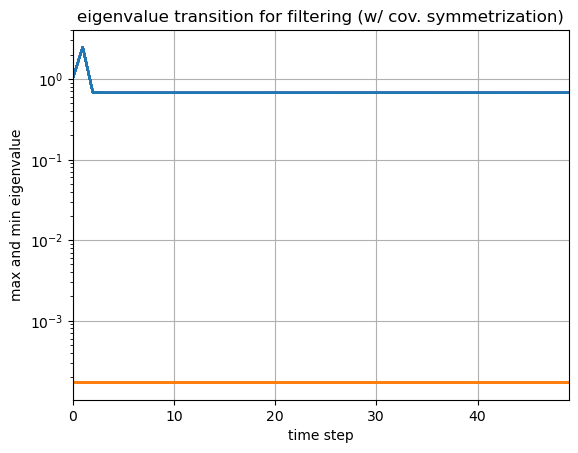

In [39]:
cmap = plt.get_cmap("tab10")
for data_num in range(eigen_values.shape[1]):
    plt.plot(np.max(eigen_values[:,data_num,:], axis=-1), color=cmap(0), alpha=0.1)
    plt.plot(np.min(eigen_values[:,data_num,:], axis=-1), color=cmap(1), alpha=0.1)
plt.yscale("log")
plt.xlim(0, 49)
plt.ylim(0, None)
plt.xlabel("time step")
plt.ylabel("max and min eigenvalue")
plt.grid()
if symmetrize_covariance:
    plt.title("eigenvalue transition for filtering (w/ cov. symmetrization)")
else:
    plt.title("eigenvalue transition for filtering (w/o cov. symmetrization)")
plt.show()

## Smoothing

In [40]:
eigen_values = []
for covariance in distribution_params["covariances"]:
    eigen_values.append(torch.linalg.svd(covariance).S.cpu().detach().numpy())
eigen_values = np.stack(eigen_values) # shape: seq_length x batch_size x dim

/tmp/ipykernel_366325/4128921116.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, None)


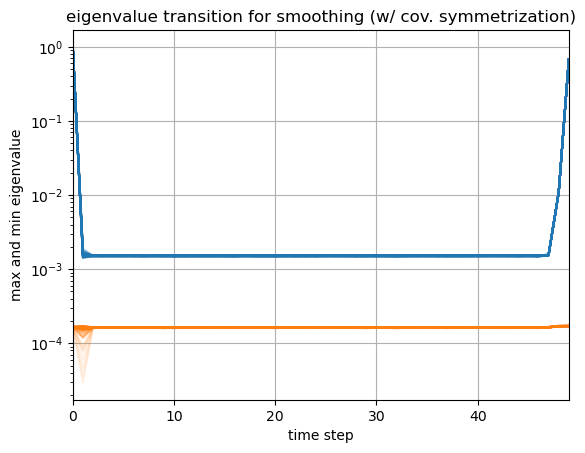

In [41]:
cmap = plt.get_cmap("tab10")
for data_num in range(eigen_values.shape[1]):
    plt.plot(np.max(eigen_values[:,data_num,:], axis=-1), color=cmap(0), alpha=0.1)
    plt.plot(np.min(eigen_values[:,data_num,:], axis=-1), color=cmap(1), alpha=0.1)
plt.yscale("log")
plt.xlim(0, 49)
plt.ylim(0, None)
plt.xlabel("time step")
plt.ylabel("max and min eigenvalue")
plt.grid()
if symmetrize_covariance:
    plt.title("eigenvalue transition for smoothing (w/ cov. symmetrization)")
else:
    plt.title("eigenvalue transition for smoothing (w/o cov. symmetrization)")
plt.show()

## Symmetry

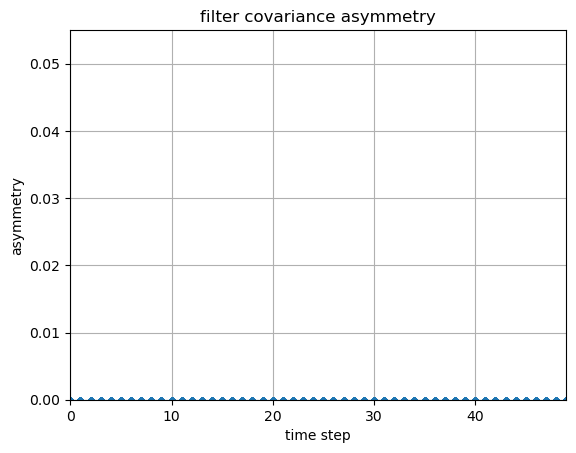

In [42]:
for time_step, covariance_batch in enumerate(distribution_params["filter_covariances"]):
    asymmetry = torch.norm(covariance_batch - covariance_batch.transpose(1, 2), p="fro", dim=(1, 2))
    plt.plot([time_step for _ in range(len(covariance_batch))], asymmetry.cpu().detach().numpy(), ".", color=cmap(0), alpha=0.2)
# plt.yscale("log")
plt.xlim(0, 49)
plt.ylim(0, None)
plt.xlabel("time step")
plt.ylabel("asymmetry")
plt.title("filter covariance asymmetry")
plt.grid()

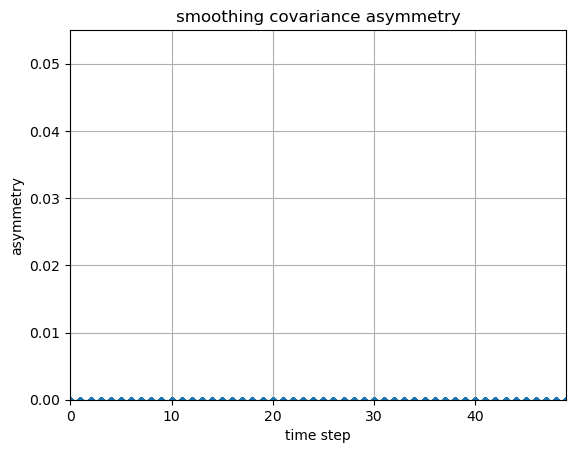

In [43]:
for time_step, covariance_batch in enumerate(distribution_params["covariances"]):
    asymmetry = torch.norm(covariance_batch - covariance_batch.transpose(1, 2), p="fro", dim=(1, 2))
    plt.plot([time_step for _ in range(len(covariance_batch))], asymmetry.cpu().detach().numpy(), ".", color=cmap(0), alpha=0.2)
# plt.yscale("log")
plt.xlim(0, 49)
plt.ylim(0, None)
plt.xlabel("time step")
plt.ylabel("asymmetry")
plt.title("smoothing covariance asymmetry")
plt.grid()

## Matrix eigenvalues

### Observation matrix

In [70]:
eigen_values = []
for time_step, mat_Cs_batch in enumerate(distribution_params["mat_Cs"]):
    eigen_values.append(torch.linalg.svd(mat_Cs_batch).S.cpu().detach().numpy())
eigen_values = np.stack(eigen_values) # shape: seq_length x batch_size x dim

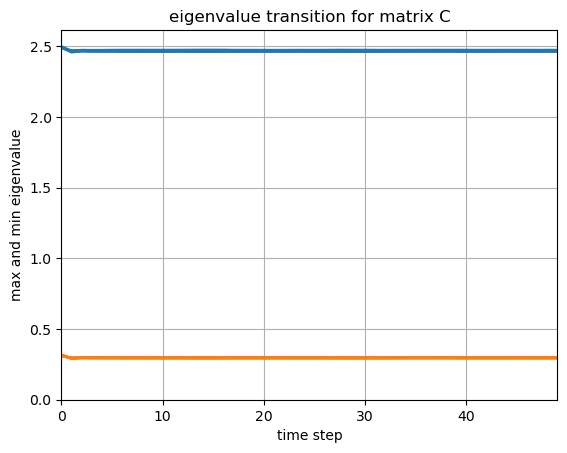

In [71]:
cmap = plt.get_cmap("tab10")
for data_num in range(eigen_values.shape[1]):
    plt.plot(np.max(eigen_values[:,data_num,:], axis=-1), color=cmap(0), alpha=0.1)
    plt.plot(np.min(eigen_values[:,data_num,:], axis=-1), color=cmap(1), alpha=0.1)
# plt.yscale("log")
plt.xlim(0, 49)
plt.ylim(0, None)
plt.xlabel("time step")
plt.ylabel("max and min eigenvalue")
plt.grid()
plt.title("eigenvalue transition for matrix C")
plt.show()

### Transition matrix

In [72]:
eigen_values = []
for time_step, mat_As_batch in enumerate(distribution_params["mat_As"]):
    eigen_values.append(torch.linalg.svd(mat_As_batch).S.cpu().detach().numpy())
eigen_values = np.stack(eigen_values) # shape: seq_length x batch_size x dim

/tmp/ipykernel_366325/1796261063.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, None)


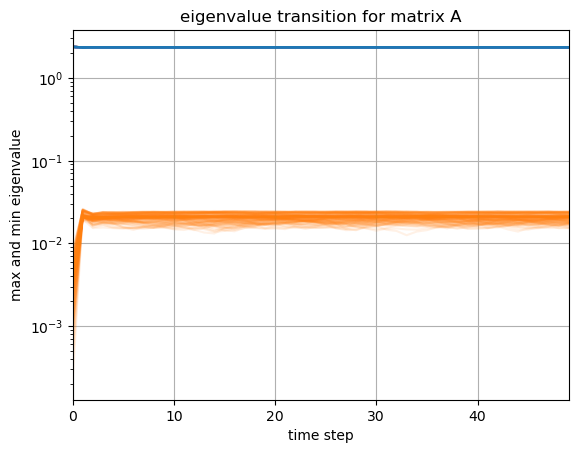

In [73]:
cmap = plt.get_cmap("tab10")
for data_num in range(eigen_values.shape[1]):
    plt.plot(np.max(eigen_values[:,data_num,:], axis=-1), color=cmap(0), alpha=0.1)
    plt.plot(np.min(eigen_values[:,data_num,:], axis=-1), color=cmap(1), alpha=0.1)
plt.yscale("log")
plt.xlim(0, 49)
plt.ylim(0, None)
plt.xlabel("time step")
plt.ylabel("max and min eigenvalue")
plt.grid()
plt.title("eigenvalue transition for matrix A")
plt.show()

### Noise matrices

In [76]:
torch.linalg.svd(kvae.state_space_model.mat_Q).S

tensor([0.8422, 0.0014, 0.0010, 0.0010], device='cuda:2',
       grad_fn=<LinalgSvdBackward0>)

In [77]:
torch.linalg.svd(kvae.state_space_model.mat_R).S

tensor([2.3047e+01, 9.9990e-04], device='cuda:2', grad_fn=<LinalgSvdBackward0>)

Even I used the 1e-3 regularization, observation noise was 